<h1> Critical Input Parameters </h1>

- All critical input parameters a user needs to set is stored here.
- Adhere to units seen in comments [conversion done in 'Solver Run']

In [43]:
# Input Paramters
from rocketpy import Fluid
# CONVERT FUNCTION
# from UnitConversion import unit_conversion

#SOLVER: General
thrust_decay = 1
discrete_segments = 100

# STRUCTURES: General
vehicle_mass_dry = 79 #lb (does not include engine)
vehicle_COM_dry_no_engine = 68 #in
vehicle_diameter = 6 #in
vehicle_height = 151 #in
rail_length = 20 #ft
launch_angle = 5 #degrees

# STRUCTURES: Tanks
tank_height_ox = 34.5 #in
tank_height_fuel = 10.3 #in
tank_position_ox = 71 #in (geometric center of tank)
tank_position_fuel = 35 #in (geometric center of tank)

# STRUCTURES: Nosecone
nosecone_height = 24 #in
nosecone_kind = "ogive"

# STRUCTURES: Fins
fin_number = 4
fin_root_chord = 9 #in
fin_tip_chord = 2.5 #in
fin_span = 5.5 #in 
fin_position = 14 #in (position is the top part of where fin starts)

# STRUCTURES: Buttons
button_position_higher = vehicle_height * (1/5) #in
button_position_lower = vehicle_height * (1/10) #in
button_angle = 45 #degrees (angle relative to symmetrical axis)

# STRUCTURES: Recovery
recovery_Cd = 0.97
recovery_diameter_drogue = 36 #in
recovery_diameter_main = 168 #in
recovery_height_trigger_main = 2000 #ft

#FLUIDS
ox_liq = Fluid(name="N2O_l", density=786.25)
ox_gas = Fluid(name="N2O_g", density=157.19) 
fuel_liq = Fluid(name="ethane_l", density=339.66) 
fuel_gas = Fluid(name="ethane_g", density=85.7) 
ox_mass_liq = 14.4 #lb
ox_mass_vap = 0 #lb
fuel_mass_liq = 2.88 #lb
fuel_mass_vap = 0 #lb

# PROPULSION
engine_thrust_initial = 1000 #lb
ox_flow_initial = 3.62 #lb/s
fuel_flow_initial = 0.721 #lb/s
engine_mass = 40 #lb
engine_COM_dry = 8 #in
engine_diameter_nozzle = 5 #in (outlet of nozzle)
engine_position_nozzle = 0 #in (vertical position of exit area)

<H1> ENVIRONMENTAL INFORMATION</H1>

- Solves for environmental information today at a random location

In [44]:
#Environmental Information

from rocketpy import Environment, Flight

env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)


import datetime
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
) #Hour given in UTC time

env.set_atmospheric_model(type="Forecast", file="GFS")

oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20240228/gfs_0p25_18z is not an available dataset"

<h1> SOLVER RUN </h1>

- Creates all object files and runs flight simulation

6.1


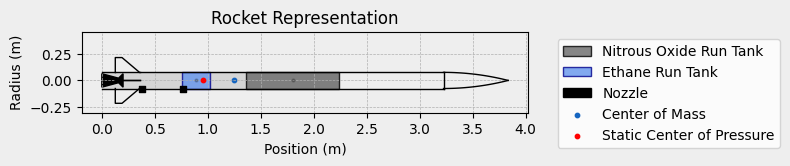

In [45]:
from rocketpy import CylindricalTank, Fluid, MassBasedTank, MassFlowRateBasedTank, LiquidMotor, Rocket, Flight
import numpy as np

#UNIT CONVERSION
# CONVERSION UNITS
in2m = 0.0254
ft2m = 0.305
lb2kg = 0.454
lbf2N = 4.45

#SOLVER: General
thrust_decay_metric = thrust_decay
discrete_segments_metric = discrete_segments

# STRUCTURES: General
vehicle_mass_dry_metric = vehicle_mass_dry * lb2kg #kg (does not include engine)
vehicle_COM_dry_no_engine_metric = vehicle_COM_dry_no_engine * in2m #m
vehicle_diameter_metric = vehicle_diameter * in2m #m
vehicle_height_metric = vehicle_height * in2m #m
rail_length_metric = rail_length * ft2m #m
launch_angle_metric = launch_angle

# STRUCTURES: Tanks
tank_height_ox_metric = tank_height_ox * in2m #m
tank_height_fuel_metric = tank_height_fuel * in2m #m
tank_position_ox_metric = tank_position_ox * in2m #m (geometric center of tank)
tank_position_fuel_metric = tank_position_fuel * in2m #m (geometric center of tank)

# STRUCTURES: Nosecone
nosecone_height_metric = nosecone_height * in2m #m
nosecone_kind_metric = nosecone_kind


# STRUCTURES: Fins
fin_number_metric = fin_number
fin_root_chord_metric = fin_root_chord * in2m #m
fin_tip_chord_metric = fin_tip_chord * in2m #m
fin_span_metric = fin_span * in2m #m 
fin_position_metric = fin_position * in2m #m (position is the top part of where fin starts)


# STRUCTURES: Buttons
button_position_higher_metric = button_position_higher * in2m #m
button_position_lower_metric = button_position_lower * in2m #m
button_angle_metric = button_angle

# STRUCTURES: Recovery
recovery_Cd_metric = recovery_Cd
recovery_diameter_drogue_metric = recovery_diameter_drogue * in2m #m
recovery_diameter_main_metric = recovery_diameter_main * in2m #m
recovery_height_trigger_main = recovery_height_trigger_main * ft2m #m

#FLUIDS
ox_liq_metric = ox_liq
ox_gas_metric = ox_gas
fuel_liq_metric = fuel_liq
fuel_gas_metric = fuel_gas
ox_mass_liq_metric = ox_mass_liq * lb2kg #kg
ox_mass_vap_metric = ox_mass_vap * lb2kg #kg
fuel_mass_liq_metric = fuel_mass_liq * lb2kg #kg
fuel_mass_vap_metric = fuel_mass_vap * lb2kg #kg

# PROPULSION
engine_thrust_initial_metric = engine_thrust_initial * lbf2N #N
ox_flow_initial_metric = ox_flow_initial * lb2kg #kg/s
fuel_flow_initial_metric = fuel_flow_initial * lb2kg #kg/s
engine_mass_metric = engine_mass * lb2kg #kg
engine_COM_dry_metric = engine_COM_dry * in2m #m
engine_diameter_nozzle_metric = engine_diameter_nozzle * in2m #m
engine_position_nozzle_metric = engine_position_nozzle * in2m #m (we define everything from the nozzle exit)


#CREATE MASS & THRUST CSVs
np.set_printoptions(suppress=True, precision=8)
ox_mass_total_metric = ox_mass_liq_metric + ox_mass_vap_metric
fuel_mass_total_metric = fuel_mass_liq_metric + fuel_mass_vap_metric
time_ox_metric = ox_mass_liq_metric / ox_flow_initial_metric
time_fuel_metric = fuel_mass_liq_metric / fuel_flow_initial_metric
timeRun_metric = min(time_ox_metric, time_fuel_metric)
if ((time_ox_metric - time_fuel_metric)/time_ox_metric) > 0.10:
    print("Over 10% deviation in time")
timeRun_array_metric = np.linspace(0, timeRun_metric, discrete_segments_metric)
ox_mass_liq_remaining_metric = ox_mass_liq_metric - (timeRun_metric * ox_flow_initial_metric) #Remaining ox after time
fuel_mass_liq_remaining_metric = fuel_mass_liq_metric - (timeRun_metric * fuel_flow_initial_metric) #Remaining fuel after time
ox_mass_change_metric = np.linspace(ox_mass_total_metric, ox_mass_vap_metric + ox_mass_liq_remaining_metric, discrete_segments_metric)
fuel_mass_change_metric = np.linspace(fuel_mass_total_metric, fuel_mass_vap_metric + fuel_mass_liq_remaining_metric, discrete_segments_metric)
engine_thrust_metric = np.linspace(engine_thrust_initial_metric, thrust_decay_metric * engine_thrust_initial_metric, discrete_segments_metric)
timeRun_array_metric = np.linspace(0, timeRun_metric, discrete_segments_metric)
ox_mass_matrix_metric = np.column_stack((timeRun_array_metric, ox_mass_change_metric))
fuel_mass_matrix_metric = np.column_stack((timeRun_array_metric, fuel_mass_change_metric))
engine_thrust_matrix_metric = np.column_stack((timeRun_array_metric, engine_thrust_metric))
np.savetxt("data/ox_mass.csv", ox_mass_matrix_metric, delimiter=",", comments='')
np.savetxt("data/fuel_mass.csv", fuel_mass_matrix_metric, delimiter=",",comments='')
np.savetxt("data/engine_thrust.csv", engine_thrust_matrix_metric, delimiter=",",comments='')

#GEOMETRY OF TANKS
oxTankGeometry = CylindricalTank(vehicle_diameter_metric/2, tank_height_ox_metric, spherical_caps=False)
fuelTankGeometry = CylindricalTank(vehicle_diameter_metric/2, tank_height_fuel_metric, spherical_caps=False)


oxTank = MassBasedTank(
    name = "Nitrous Oxide Run Tank",
    geometry = oxTankGeometry,
    liquid = ox_liq_metric,
    gas = ox_gas_metric,
    liquid_mass = "./data/ox_mass.csv",
    gas_mass = ox_mass_vap_metric,
    flux_time = timeRun_metric
)

fuelTank = MassBasedTank(
    name = "Ethane Run Tank",
    geometry = fuelTankGeometry,
    liquid = fuel_liq_metric,
    gas = fuel_gas_metric,
    liquid_mass = "./data/fuel_mass.csv",
    gas_mass = fuel_mass_vap_metric,
    flux_time = timeRun_metric
)

theEngine = LiquidMotor(  
    thrust_source = "./data/engine_thrust.csv",
    dry_mass = engine_mass_metric,
    dry_inertia = (0.125, 0.125, 0.002), #dumb values
    nozzle_radius = engine_diameter_nozzle_metric/2,
    center_of_dry_mass_position = engine_COM_dry_metric, 
    nozzle_position = engine_position_nozzle_metric,
    burn_time = timeRun_metric,
    coordinate_system_orientation = "nozzle_to_combustion_chamber"
)
theEngine.add_tank(tank=oxTank, position = tank_position_ox_metric)
theEngine.add_tank(tank=fuelTank, position = tank_position_fuel_metric)

theRocket = Rocket(
    radius = vehicle_diameter_metric/2,
    mass = vehicle_mass_dry_metric,
    center_of_mass_without_motor = vehicle_COM_dry_no_engine_metric,
    inertia = (6.321, 6.321, 0.034), #dumb values
    power_off_drag = "./data/dragCurve.csv",
    power_on_drag = "./data/dragCurve.csv",
    coordinate_system_orientation = "tail_to_nose"
)
theRocket.add_motor(
    motor = theEngine,
    position = engine_position_nozzle_metric
)

nose_cone = theRocket.add_nose(
    length=nosecone_height_metric,
    kind=nosecone_kind_metric,
    position=vehicle_height_metric)
fin_set = theRocket.add_trapezoidal_fins(
    n=fin_number_metric,
    root_chord=fin_root_chord_metric,
    tip_chord=fin_tip_chord_metric,
    span=fin_span_metric,
    position=fin_position_metric)
railButtons = theRocket.set_rail_buttons(
    upper_button_position=button_position_higher_metric,
    lower_button_position=button_position_lower_metric,
    angular_position=button_angle_metric)

#Rest parachutes list (issues with .append adding duplicates)
if theRocket.parachutes:
    theRocket.parachutes.clear()
drogue = theRocket.add_parachute(
    name="Drogue",
    cd_s=recovery_Cd_metric * (np.pi/4) * recovery_diameter_drogue_metric**2,
    trigger="apogee",
    sampling_rate=105,
    lag=0, 
)

main = theRocket.add_parachute(
    name="Main",
    cd_s=recovery_Cd_metric * (np.pi/4) * recovery_diameter_main_metric**2,
    trigger=recovery_height_trigger_main,
    sampling_rate=105,
    lag=0,
)
test_flight = Flight(
    rocket=theRocket, environment=env, rail_length=rail_length_metric, inclination=90-launch_angle_metric, heading=0
) 

print(rail_length_metric)
from rocketpy import rocket
theRocket.draw()

<h1> OUTPUT: NUMERICAL VALUES

In [46]:
import numpy as np
import math

#DATA OUTPUT
dryMass = theRocket.mass + theEngine.dry_mass

#Solving Static_margin
timeSteps = np.linspace(0, timeRun_metric, 100)
staticMarginOutputs = theRocket.static_margin(timeSteps)
maxStaticMargin = max(staticMarginOutputs)
minStaticMargin = min(staticMarginOutputs)

#Solving Average Thrust on Rail
timeRail = np.linspace(0, test_flight.out_of_rail_time, 100)
outputThrustOutputs = theEngine.thrust(timeRail)
outputRailMass = theRocket.total_mass(timeRail)
averageRailThrust = np.mean(outputThrustOutputs)
averageRailWeight = (np.mean(outputRailMass) * 9.81) #Keep in metric since thrust in newtons

#print(outputThrustOutputs)

#Seconds of each event
timeDrogueDeploy = (test_flight.parachute_events[0][0])
timeMainDeploy = (test_flight.parachute_events[1][0])
timeImpact = (test_flight.t_final)

#Solving Average Drogue Descent Speed
elements = 100
timeDrogue = np.linspace(timeDrogueDeploy, timeMainDeploy, elements)
outputDrogueDescentSpeed = (test_flight.vz(timeDrogue)) / (in2m * 12) #Convert to ft/s
averageDrogueDescentSpeed = np.average(outputDrogueDescentSpeed)
maxDrogueDescentSpeed = min(outputDrogueDescentSpeed) #min() called since we are dealing with negative floats
minDrogueDescentSpeed = max(outputDrogueDescentSpeed[5:elements-5]) #ignore first 5 elements

#Solving altitude main descent velocity brought under 30 ft/s
timeMain = np.linspace(timeMainDeploy, timeImpact, 100)
timeMainThreshold = False #Initializing to default if trigger never reached. This will describe the time the vehicle descent speed is below 30ft/s
#index all except last value just in case impact has weird effect
for t in timeMain[:-1]:
    descentSpeedImperial = test_flight.vz(t) / (in2m * 12)
    if descentSpeedImperial < 30:
        timeMainThreshold = t
        break
if timeMainThreshold:
    altitudeMainThreshold = (test_flight.z(timeMainThreshold) - env.elevation)/ (in2m * 12)
else:
    altitudeMainThreshold = "NEVER"
        
#Max Dynamic Pressure

#Output Data I Need
print("INPUTS")
print(f"Rocket Wet Mass: {theRocket.total_mass(0)} kg")
print(f"Rocket Dry Mass with Payload: {dryMass} kg")
print(f"Ox Mass: {oxTank.liquid_mass(0)} kg")
print(f"Fuel Mass: {fuelTank.liquid_mass(0)} kg")
print("")


print("OUTPUTS")
print(f"Apogee: {(test_flight.apogee - env.elevation) / (in2m * 12)} ft")
print(f"Total Impulse: {theEngine.total_impulse} Ns")
print(f"Estimated Burn Time: {theEngine.burn_duration} s")
print(f"Max Static Margin: {(maxStaticMargin)} cal")
print(f"Min Static Margin: {(minStaticMargin)} cal")
print(f"Max Velocity: {(test_flight.max_speed) / (in2m * 12)} ft/s")
print(f"Max Mach: {(test_flight.max_mach_number)}")
print(f"Average Thrust on Rail: {averageRailThrust} N")
print(f"Rail Exit Velocity: {(test_flight.out_of_rail_velocity) / (in2m * 12)} ft/s")
print(f"TTW on Rail: {averageRailThrust / averageRailWeight}")
print(f"Average Drogue Descent from Apogee: {averageDrogueDescentSpeed} ft/s")
print(f"Max Drogue Descent Speed from Apogee: {maxDrogueDescentSpeed} ft/s")
print(f"Min Drogue Descent Speed from Apogee: {minDrogueDescentSpeed} ft/s")
print(f"Altitude where descent < 30 ft/s: {altitudeMainThreshold} ft")
print(f"Ground Hit Velocity: {test_flight.impact_velocity/(in2m * 12)} ft/s")

INPUTS
Rocket Wet Mass: 61.871120000000005 kg
Rocket Dry Mass with Payload: 54.025999999999996 kg
Ox Mass: 6.5376 kg
Fuel Mass: 1.30752 kg

OUTPUTS
Apogee: 11143.044601419497 ft
Total Impulse: 17701.657458563543 Ns
Estimated Burn Time: 3.977900552486188 s
Max Static Margin: 1.8898358673474782 cal
Min Static Margin: 1.675997181833035 cal
Max Velocity: 856.9808157197291 ft/s
Max Mach: 0.7852099931786888
Average Thrust on Rail: 4450.0 N
Rail Exit Velocity: 84.9000009551697 ft/s
TTW on Rail: 7.380231599434322
Average Drogue Descent from Apogee: -112.81363578736216 ft/s
Max Drogue Descent Speed from Apogee: -257.4707955442383 ft/s
Min Drogue Descent Speed from Apogee: -80.91706184979068 ft/s
Altitude where descent < 30 ft/s: 2000.9272835803586 ft
Ground Hit Velocity: -22.55382856677235 ft/s


<h1> OUTPUT: STATIC MARGIN </h1>

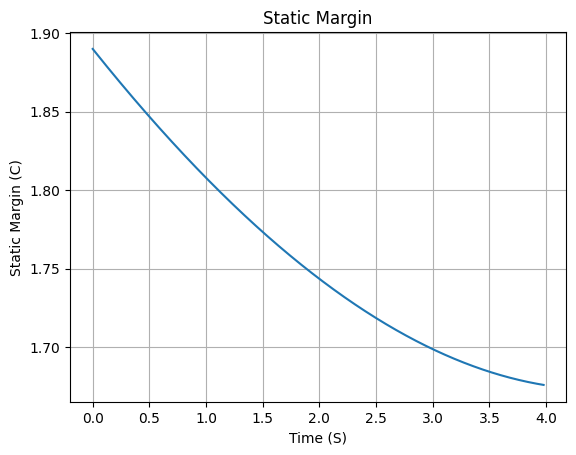

In [47]:
from rocketpy import plots
theRocket.plots.static_margin()

<h1> OUTPUT: TRAJECTORY </h1>

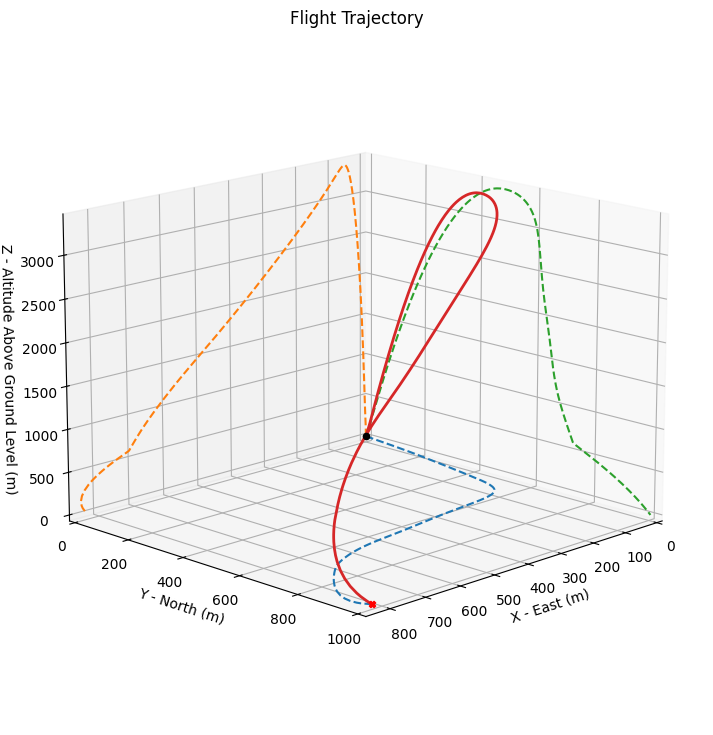

In [48]:
from rocketpy import plots
test_flight.plots.trajectory_3d()

<h1> BENDING MOMENT CALCULATIONS </h1>

In [49]:
#BENDING MOMENT CALCULATIONS
#Collect input variables:
CoP = theRocket.cp_position ((test_flight.max_mach_number)) #[m] from the bottom of the rocket
maxVelocity = (test_flight.max_speed)  #[m]
maxCrosswind = 16 #[m/s], tentatively. rocketpy may have a function for this
angleIronThickness = 0.003175 #[m]
angleIronWidth = 0.0254 #[m]
angleIronHeight = 1.4986 #[m]
angleIronArea = angleIronWidth**2 - (angleIronWidth-angleIronThickness)**2
angleIronAmount = 3 #[]
Cd = 1 #[], tentatively
#vehicle height is stored in heightVehicle, diameter is stored in diameter
tankThickness = .1625 * 0.0254 #[m]
thrustForce = 1000 * 4.44822 #[N]
maxAngle = 0.0872665 #[rad]
tankPressure = 1000 * 6894.76 #[Pa]
rho = 1.225 #[kg/m^3]
rocketDiam = diameter
aluminumModulus = 68*10**9 #[Pa]

#Calculate moments of inertia:
singleAngleIronMoI = (angleIronThickness)*(angleIronWidth)**3 / 3 + (angleIronWidth-angleIronThickness)*(angleIronThickness)**3 / 3 #[m^4]
totalAngleIronMoI = angleIronAmount * (singleAngleIronMoI + angleIronArea*(diameter/2)**2) #[m^4]
aluminumShellMoI = (math.pi / 64) * (rocketDiam**4 - (rocketDiam - 2*tankThickness)**4)#[m^4]
tankCrossSectionalArea = (math.pi / 4) * (rocketDiam**2 - (rocketDiam - 2*tankThickness)**2) #[m^2]

#Calculate the bending moment
totalWind = math.sin(maxAngle) * maxVelocity + maxCrosswind
profileAreaTop = (heightVehicle - CoP) * diameter #[m^2]
profileAreaBottom = CoP * diameter #[m^2]
forceWindTop = 0.5 * profileAreaTop * Cd * rho * totalWind**2 #[N]
forceWindBottom =  0.5 * profileAreaBottom * Cd * rho * totalWind**2 #[N]
forceWindTopDistance = (heightVehicle - CoP) / 2
forceWindBottomDistance = CoP / 2
bendingMoment = forceWindTop * forceWindTopDistance

#Calculating Buckling Load
bucklingConstant = 0.25 # held at bottom, unconstrained at top
aluminumBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * aluminumShellMoI / heightVehicle
angleIronBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * totalAngleIronMoI / angleIronHeight
singleAngleIronBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * singleAngleIronMoI / angleIronHeight
print("Buckling Load of entire vehicle: ", "{:.4f}".format(aluminumBucklingLoad), "N (", "{:.4f}".format(aluminumBucklingLoad*0.2248), "lbs )")
print("Buckling Load of", angleIronAmount, "angle irons: ", "{:.4f}".format(angleIronBucklingLoad), "N (", "{:.4f}".format(angleIronBucklingLoad*0.2248), "lbs )")
print("Buckling Load of single angle iron: ", "{:.4f}".format(singleAngleIronBucklingLoad), "N (", "{:.4f}".format(singleAngleIronBucklingLoad*0.2248), "lbs )")

#Calculating Bending Stresses:
tankBendingStress = bendingMoment * (rocketDiam/2) / aluminumShellMoI
angleIronBendingStress = bendingMoment * (rocketDiam/2 + angleIronWidth/2) / totalAngleIronMoI
print("Maximum bending stress in tank:", "{:.4f}".format(tankBendingStress/10**6), "MPa (", "{:.4f}".format(aluminumBucklingLoad/10**6 * 0.1450377377), "ksi )")
print("Maximum angle iron bending stress:", "{:.4f}".format(angleIronBendingStress/10**6), "MPa (", "{:.4f}".format(angleIronBendingStress/10**6 * 0.1450377377), "ksi )")

#Calculate Pressure Stresses:
p_o = 101352 #[Pa]
p_i = tankPressure #[Pa]
r_i = rocketDiam/2 - tankThickness #[m]
r_o = rocketDiam/2 #[m]
tankLongStress = (p_i*r_i**2 - p_o*r_o**2) / (r_o**2 - r_i**2) 
tankHoopStress = (p_i*r_i**2 - p_o*r_o**2) / (r_o**2 - r_i**2) - r_i**2 * r_o**2 * (p_o - p_i) / (r_o**2 * (r_o**2 - r_i**2))
print("Tank Longitudinal stress in tank:", "{:.4f}".format(tankLongStress/10**6), "MPa (", "{:.4f}".format((tankLongStress/10**6 * 0.1450377377)), "ksi )")
print("Tank Hoop Stress in tank:", "{:.4f}".format(tankHoopStress/10**6), "MPa (", "{:.4f}".format(tankHoopStress/10**6 * 0.1450377377), "ksi )")

# Compile pressure sum:
tankAxialStress = tankBendingStress + tankLongStress - thrustForce / tankCrossSectionalArea
#tankVonMises = math.sqrt(tankAxialStress**2 + tankHoopStress**2 - tankAxialStress*tankHoopStress)
#print("Resultant Von Mises Stress =", "{:.4f}".format(tankVonMises/10**6), "MPa (", "{:.4f}".format(tankVonMises/10**6 * 0.1450377377), "ksi )")

NameError: name 'diameter' is not defined